In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks


def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

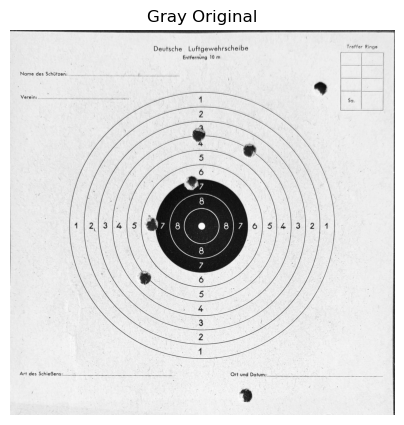

In [141]:
image = io.imread(f'resources/aligned/shot_6.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(gray_image, cmap="gray", size=(5,5), name="Gray Original")

## Ringerkennung

### 1. CV2 Hough Circle Transformation

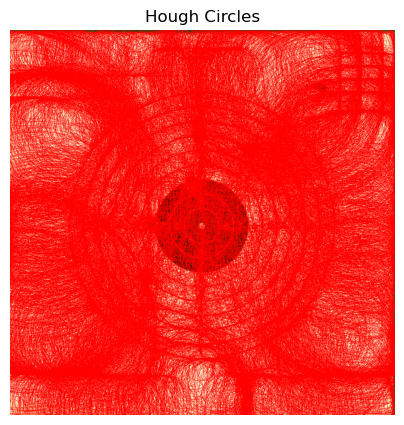

In [142]:
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=150, param2=30, minRadius=0, maxRadius=0)
circles = np.round(circles[0, :]).astype("int")
marked = image.copy()
for (x, y, r) in circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 1)
show_image(marked, size=(5,5), name="Hough Circles")

Cons
- Sehr ungenau

Für Kreise die ungefähr in der Mitte des Bildes sind: 

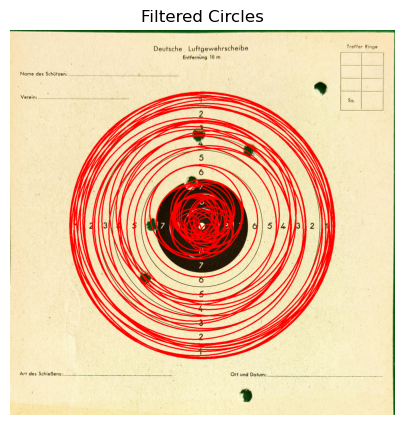

In [143]:
filtered_circles = []
height, width = image.shape[:2]
width = int(width/2)
height = int(height/2)
tollerance = 50
for (x, y, r) in circles:
    if (x > width - tollerance) and (x < width+tollerance) and (y > height-tollerance) and (y < height+tollerance):
        filtered_circles.append((x, y, r))

marked = image.copy()
for (x, y, r) in filtered_circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 3)
show_image(marked, size=(5, 5), name="Filtered Circles")

### 2. Größte Kontur finden

Steps:
1. Bild in Graubild konvertieren
2. Median Filter zum entfernen von Salt&Pepper
3. Kantenerkennung mithilfe von Sobel Filter oder Canny
4. Konturen finden
5. Nach Kontur suchen mit größtem Radius
6. Mittelpunkt bestimmten durch Zentrum des minimal umschließenden Kreis

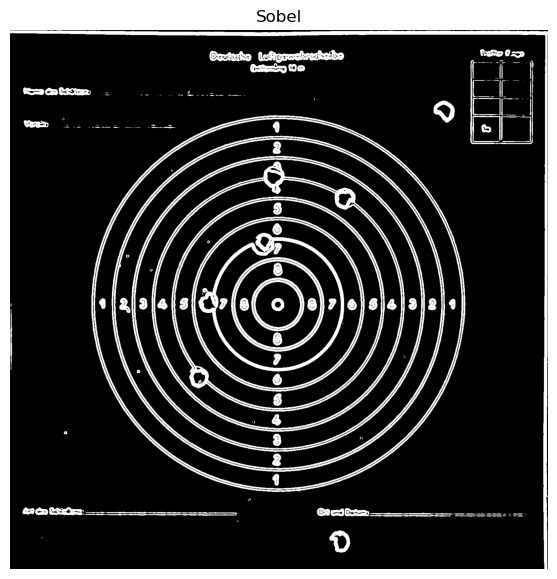

In [144]:
gray_image_blur = cv2.GaussianBlur(gray_image, (15,15), 0)
sobelx = cv2.Sobel(gray_image_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image_blur, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255

show_image(sobel, cmap="gray", size=(7,7), name="Sobel")

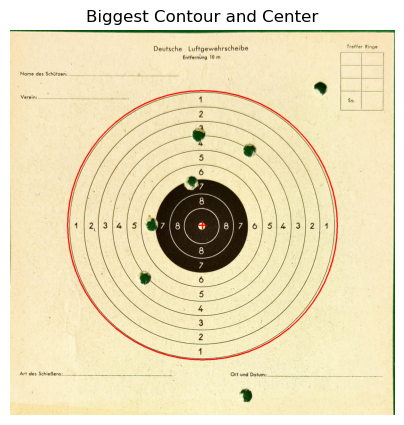

In [145]:
contours, _ = cv2.findContours(sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    area = cv2.contourArea(contour)
    total = area * radius
    if total > biggest_radius:
        biggest_radius = total
        biggest_cntr = contour

# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)

cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5), name="Biggest Contour and Center")

Pro:
- Relativ schnell </br>
<!-- -->
Con:
- Kreis und Mittelpunkt nicht unbedingt genau. Sehr abhängig von Aufnahmewinkel. Zielscheibe müsste Perfekt von vorne aufgenommen werden

### 3. Alternativer Hough Circle Transformation Ansatz

Steps
1. Rand des Bildes auf schwarz ändern, aufgrund schlechter Aufnahme
2. Erode & Dilate um Artefakte zu entfernen
3. Konturen finden
5. Nach Kontur suchen mit größtem Radius
6. Mittelpunkt bestimmten durch Zentrum des minimal umschließenden Kreis

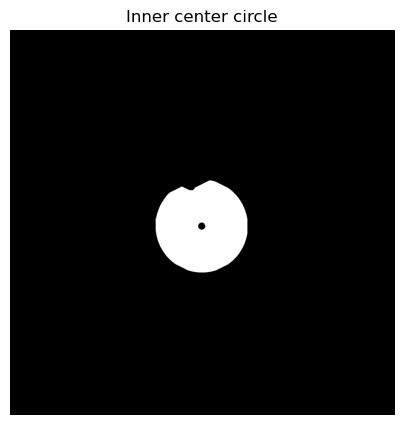

In [146]:
res = gray_image.copy()
border_width=50
res[:border_width, :] = 255
res[-border_width:, :] = 255
res[:, :border_width] = 255
res[:, -border_width:] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel, res, iterations=3)
cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, res, iterations=25)
threshold = 80
res[res < threshold] = 0
res[res >= threshold] = 255
res = cv2.bitwise_not(res)
show_image(res, cmap="gray", size=(5,5), name="Inner center circle")

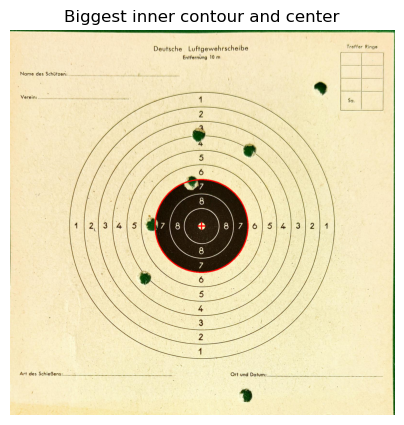

In [147]:
contours, _ = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    if radius > biggest_radius:
        biggest_radius = radius
        biggest_cntr = contour
# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)
cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5), name='Biggest inner contour and center')

### 4. Punkte finden mit gemeinsamen Radius

Pre: Mittelpunkt der Zielscheibe muss bestimmt worden sein

Steps:
</br>
1. Alle Punkte durchgehen und Abstand zum Mittelpunkt messen
2. Punkte die sich Radius teilen in dict abspeichern
3. Für alle Peaks über Treshhold Kreis mit entsprechendem Radius zeichnen

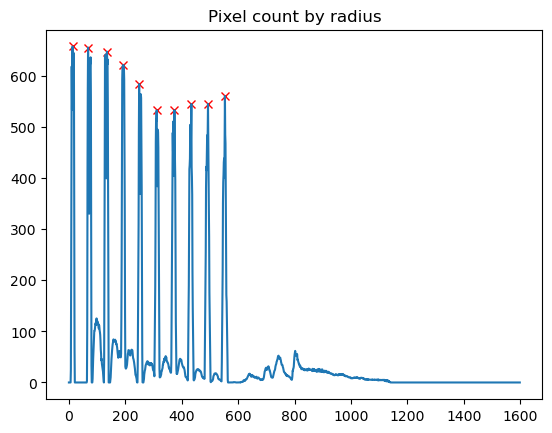

In [148]:
def hough_circles_around_center(image, fix,img):
    dict = {}
    height, width = image.shape
    acc_length_factor = 1
    length_acc = width * acc_length_factor
    acc = np.zeros(length_acc)
    x_f, y_f = fix
    for x in range(0, width):
        for y in range(0, height):

            if image[y, x] > 0:
                radius = np.floor(
                    np.sqrt((x_f - x)**2 + (y_f - y)**2) * acc_length_factor).astype("int")
                if not radius in dict:
                    dict[radius]=[]
                acc[radius] = acc[radius] + 1
                dict[radius].append((x,y))

    # Kleiner Radius = weniger Punkte auf dem Kreis
    acc = acc / ((np.arange(len(acc))+1)/acc_length_factor)
    acc = acc * 100
    max = np.max(acc)
    peaks, _ = find_peaks(acc, prominence=1, distance=40, height=0.5*max)

    plt.plot(peaks,  acc[peaks], "xr")
    plt.plot(acc)
    plt.title("Pixel count by radius")
    plt.show()

    summed={}
    for peak in peaks:
        if not peak in summed:
            summed[peak]=[]
        for r in range(-15,15):
            if (peak+r) in dict:
                summed[peak].extend(dict[peak+r])


    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return (peaks/acc_length_factor).astype("int"),summed

circles,summed = hough_circles_around_center(sobel, (centerX, centerY),image)

Zeichnen der Kreise

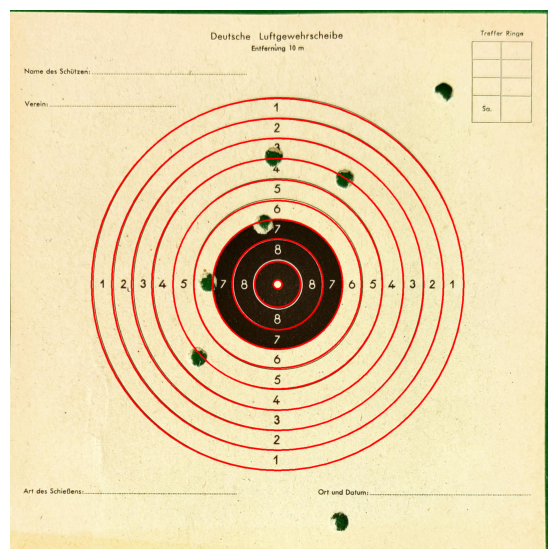

In [149]:
marked = image.copy()
for r in circles: 
    marked = cv2.circle(marked, (centerX, centerY), r, (255, 0, 0), 3)
show_image(marked, size=(7, 7))

Als Zusatz werden in der hough_circles_around_center-Methode 
- Punkte nach ihrem Radius in ein Dictionary gespeichert
- Nach dem finden der Peaks werden diese als Key verwendet um aus dem Dictionary die entsprechenden Punkte auszulesen und zusammen mit ihren linken und rechten Nachbarn (Radius+-8) in ein neues dictionary "summed" zu speichern.
- Summed enthält jetzt pro peak ein Punktarray, welches verwendet wird um mithilfe von cv2.elipses eine Elipse zu bestimmen

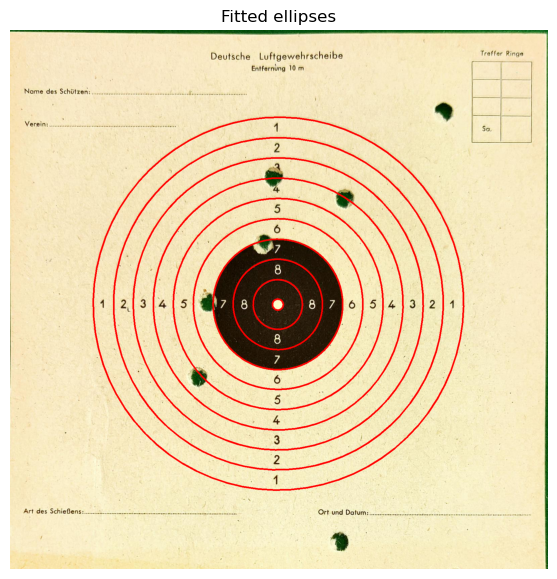

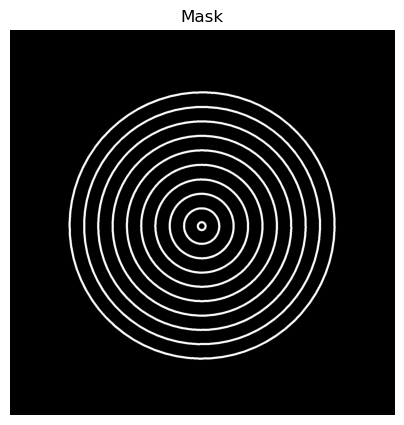

In [150]:
mask = np.zeros_like(gray_image)
marked = image.copy()
ellipses = []
for elem in summed.values():
    ellipse = cv2.fitEllipse(np.array(elem))
    ellipses.append(ellipse)    
    cv2.ellipse(mask, ellipse, 255, 8)
    cv2.ellipse(marked, ellipse, (255, 0, 0), 4)
show_image(marked,size=(7,7), name="Fitted ellipses")
show_image(mask, cmap="gray", size=(5,5), name="Mask")

Mask benutzen zum ausblenden der Punktkreise

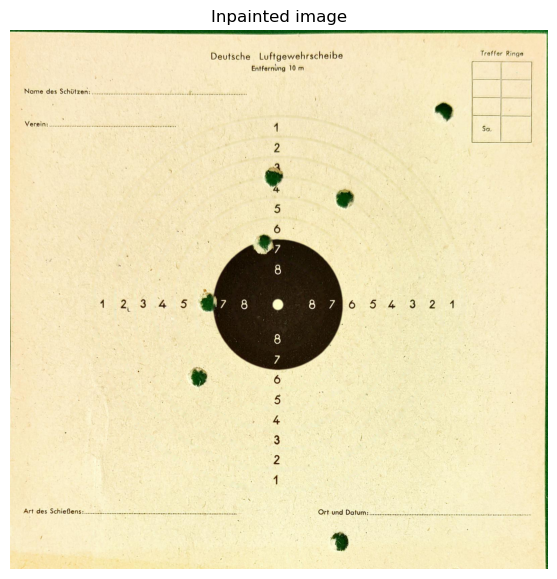

In [151]:
inpainted = cv2.inpaint(image, mask, 4, cv2.INPAINT_TELEA)
show_image(inpainted, size=(7,7), name="Inpainted image")

Filtern des Bilds nach grünem Hintergrund

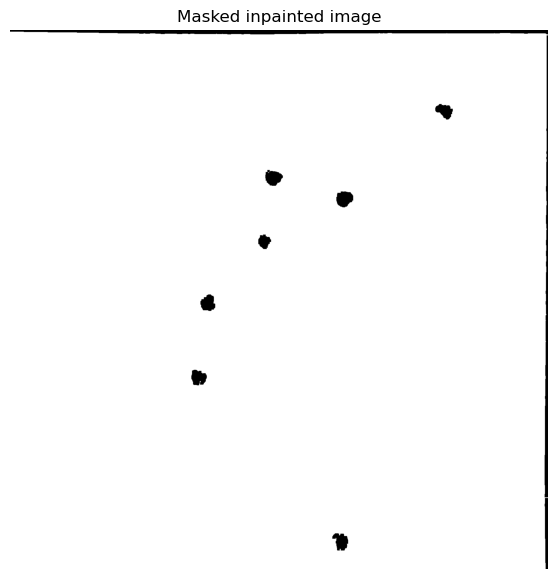

In [152]:
# convert the BGR image to HSV colour space
hsv = cv2.cvtColor(inpainted, cv2.COLOR_BGR2HSV)
# set the lower and upper bounds for the green hue
lower_green = np.array([20, 80, 20])
upper_green = np.array([90, 255, 255])
# create a mask for green colour using inRange function
mask = cv2.inRange(hsv, lower_green, upper_green)
# perform bitwise and on the original image arrays using the mask
masked_inpaint = cv2.bitwise_and(inpainted, inpainted, mask=mask)
masked_inpaint = cv2.cvtColor(masked_inpaint, cv2.COLOR_BGR2GRAY)
threshold = 10
masked_inpaint[masked_inpaint < threshold] = 0
masked_inpaint[masked_inpaint >= threshold] = 255

masked_inpaint = cv2.bitwise_not(masked_inpaint)
# dilate the masked image to fill in holes
kernel = np.ones((3, 3), np.uint8)
masked_inpaint = cv2.dilate(masked_inpaint, kernel, iterations=3)
masked_inpaint = cv2.erode(masked_inpaint, kernel, iterations=3)
show_image(masked_inpaint, cmap='gray', size=(7, 7), name="Masked inpainted image")

Verwenden eines Blob Detectors zum finden der Einschusslöcher

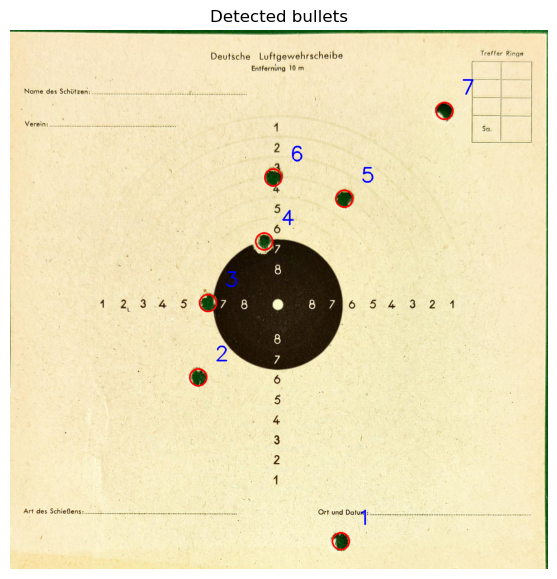

In [153]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 700
params.maxArea = 500000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(masked_inpaint)
marked = inpainted.copy()
counter = 1
for keypoint in keypoints:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
    cv2.putText(marked, str(counter), (x+50, y-50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    counter += 1
    cv2.circle(marked, (x, y), 25, (255, 0, 0), 3)
show_image(marked, size=(7, 7), name="Detected bullets")

Score

In [154]:
def check_circle_ellipse_intersection(ellipse_center, ellipse_major_axis, ellipse_minor_axis, circle_center, circle_radius):
    # Calculate distance between centers
    dx = ellipse_center[0] - circle_center[0]
    dy = ellipse_center[1] - circle_center[1]
    distance = np.sqrt(dx**2 + dy**2)

    # Calculate sum of radii and axes
    sum_radii_axes = circle_radius + (ellipse_major_axis + ellipse_minor_axis) / 2

    # Check if circle intersects ellipse
    if distance <= sum_radii_axes:
        print("Circle intersects ellipse")
    else:
        print("Circle does not intersect ellipse")

    # Calculate distance between centers
    dx = ellipse_center[0] - circle_center[0]
    dy = ellipse_center[1] - circle_center[1]
    distance = np.sqrt(dx**2 + dy**2)

    # Calculate sum of major and minor axes
    sum_axes = ellipse_major_axis + ellipse_minor_axis

    # Check if circle is inside ellipse
    if distance < sum_axes:
        print("Circle is inside ellipse")        
        return True        
    else:
        print("Circle is not inside ellipse")
        return False

In [155]:
def is_point_inside_ellipse(x, y, cx, cy, a, b, theta):
    # Convert angle to radians
    theta = np.radians(theta)

    # Calculate rotated coordinates
    x_rot = (x - cx) * np.cos(theta) + (y - cy) * np.sin(theta)
    y_rot = (y - cy) * np.cos(theta) - (x - cx) * np.sin(theta)

    # Check if point is inside ellipse
    return (x_rot / a)**2 + (y_rot / b)**2 <= 1

In [156]:
def check_circle_in_ellipse(ellipse_center, ellipse_major_axis, ellipse_minor_axis, angle, circle_center, circle_radius):
    # Calculate distance between centers
    dx = circle_center[0] - ellipse_center[0] 
    dy = circle_center[1] - ellipse_center[1] 
    distance = np.sqrt(dx**2 + dy**2)
    if(distance < circle_radius):
        print("Circle is inside ellipse smoll radius")
        return True    
    x = dx /distance*(distance-circle_radius)+ellipse_center[0]
    y = dy /distance*(distance-circle_radius)+ellipse_center[1]
    # kek = image.copy()
    # cv2.drawMarker(kek, (int(x), int(y)), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
    # show_image(kek, size=(7, 7), name="AYY")
    # print(x,y)    
    # cos_angle = np.cos(np.radians(180.-angle))
    # sin_angle = np.sin(np.radians(180.-angle))

    # xc = x - ellipse_center[0]
    # yc = y - ellipse_center[1]

    # xct = xc * cos_angle - yc * sin_angle
    # yct = xc * sin_angle + yc * cos_angle 
    # rad_cc = (xct**2/(ellipse_major_axis)**2) + (yct**2/(ellipse_minor_axis)**2)
    # if(rad_cc <= 1.):
    #     print("Circle is inside ellipse")
    #     return True    
    # return False
    return is_point_inside_ellipse(x, y, ellipse_center[0], ellipse_center[1], ellipse_major_axis, ellipse_minor_axis, angle)





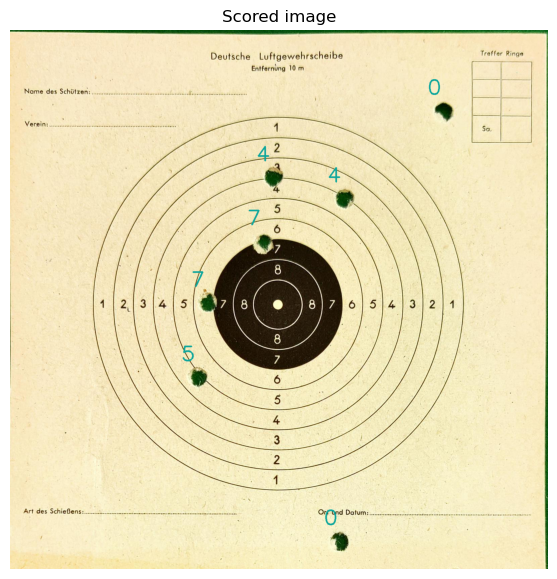

In [157]:
def calculate_score(image, keypoints):    
    for keypoint in keypoints:
        score = 0
        x = int(keypoint.pt[0])-50
        y = int(keypoint.pt[1])-50
        for i, ellipse in enumerate(ellipses):
            major_axis = ellipse[1][0] / 2
            minor_axis = ellipse[1][1] / 2
            center = ellipse[0]
            angle = ellipse[2]
            if(check_circle_in_ellipse(center, major_axis, minor_axis, angle, keypoint.pt, 25)):
                score = len(ellipses) - i
                break
        cv2.putText(image, str(score), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (13, 166, 156), 3)            
copy = image.copy()
calculate_score(copy, keypoints)
show_image(copy, size=(7, 7), name="Scored image")
